<a href="https://colab.research.google.com/github/Rishiatweb/Wildfire-detection/blob/main/Forest_Fire_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
##direct import as similar to kaggle code
import kagglehub
read_only_path = kagglehub.dataset_download("abdelghaniaaba/wildfire-prediction-dataset")
print("Path to dataset files:", read_only_path)

Path to dataset files: /kaggle/input/wildfire-prediction-dataset


In [34]:
import shutil

# Define the source (read-only) and destination (writable) paths
source_dir = read_only_path
writable_dir = "/content/wildfire_dataset_writable"

# Copy the entire directory tree
print(f"\nCopying dataset from {source_dir} to {writable_dir}...")
if os.path.exists(writable_dir):
    shutil.rmtree(writable_dir) # Remove if it exists to ensure a fresh copy
shutil.copytree(source_dir, writable_dir)
print("Copying complete.")

# --- IMPORTANT: Update path variables to point to the new writable directories ---
train_dir = os.path.join(writable_dir, 'train')
valid_dir = os.path.join(writable_dir, 'valid')
test_dir = os.path.join(writable_dir, 'test')

# Verify the new paths
print("\nUpdated paths to writable directories:")
print(f"Train directory: {train_dir} (Exists: {os.path.exists(train_dir)})")
print(f"Validation directory: {valid_dir} (Exists: {os.path.exists(valid_dir)})")
print(f"Test directory: {test_dir} (Exists: {os.path.exists(test_dir)})")


Copying dataset from /kaggle/input/wildfire-prediction-dataset to /content/wildfire_dataset_writable...
Copying complete.

Updated paths to writable directories:
Train directory: /content/wildfire_dataset_writable/train (Exists: True)
Validation directory: /content/wildfire_dataset_writable/valid (Exists: True)
Test directory: /content/wildfire_dataset_writable/test (Exists: True)


In [38]:
import tensorflow as tf

def find_and_remove_tf_unreadable_images(base_dir):
    corrupt_files = []
    total_files = 0
    print(f"Scanning directory: {base_dir}")
    for root, _, files in os.walk(base_dir):
        for file in files:
            total_files += 1
            file_path = os.path.join(root, file)
            try:
                raw_image = tf.io.read_file(file_path)
                tf.io.decode_jpeg(raw_image)
            except tf.errors.InvalidArgumentError as e:
                print(f"--> Found problematic file for TensorFlow: {file_path}")
                corrupt_files.append(file_path)
            except Exception as e:
                print(f"--> Found other problematic file: {file_path} - Error: {e}")
                corrupt_files.append(file_path)

    if corrupt_files:
        print(f"\nFound {len(corrupt_files)} problematic files. Removing them...")
        for file_path in corrupt_files:
            try:
                os.remove(file_path)
                print(f"Successfully removed: {file_path}")
            except OSError as e:
                print(f"Error removing file {file_path}: {e}")
        print("Removal complete.")
    else:
        print("No problematic files found by TensorFlow decoder.")
    print(f"\nScanned {total_files} files in total in {base_dir}.")

# --- Run the cleaning process on the writable copies ---
print("\n--- Cleaning Writable Train Directory ---")
find_and_remove_tf_unreadable_images(train_dir)
print("\n--- Cleaning Writable Validation Directory ---")
find_and_remove_tf_unreadable_images(valid_dir)
print("\n--- Cleaning Writable Test Directory ---")
find_and_remove_tf_unreadable_images(test_dir)
print("\n\nDataset cleaning finished. Proceeding to load data...")


--- Cleaning Writable Train Directory ---
Scanning directory: /content/wildfire_dataset_writable/train
No problematic files found by TensorFlow decoder.

Scanned 30249 files in total in /content/wildfire_dataset_writable/train.

--- Cleaning Writable Validation Directory ---
Scanning directory: /content/wildfire_dataset_writable/valid
No problematic files found by TensorFlow decoder.

Scanned 6300 files in total in /content/wildfire_dataset_writable/valid.

--- Cleaning Writable Test Directory ---
Scanning directory: /content/wildfire_dataset_writable/test
No problematic files found by TensorFlow decoder.

Scanned 6299 files in total in /content/wildfire_dataset_writable/test.


Dataset cleaning finished. Proceeding to load data...


In [39]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay

In [40]:
#Constants to play around with
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_dataset = image_dataset_from_directory(
    train_dir, labels='inferred', label_mode='binary', image_size=IMG_SIZE,
    interpolation='nearest', batch_size=BATCH_SIZE, shuffle=True)

validation_dataset = image_dataset_from_directory(
    valid_dir, labels='inferred', label_mode='binary', image_size=IMG_SIZE,
    interpolation='nearest', batch_size=BATCH_SIZE, shuffle=False)

test_dataset = image_dataset_from_directory(
    test_dir, labels='inferred', label_mode='binary', image_size=IMG_SIZE,
    interpolation='nearest', batch_size=BATCH_SIZE, shuffle=False)

class_names = train_dataset.class_names
print("Class Names:", class_names)

Found 30249 files belonging to 2 classes.
Found 6300 files belonging to 2 classes.
Found 6299 files belonging to 2 classes.
Class Names: ['nowildfire', 'wildfire']


In [41]:
data_augmentation = Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
], name="data_augmentation")

In [42]:
custom_cnn = Sequential([
    Input(shape=IMG_SIZE + (3,)),
    tf.keras.layers.Rescaling(1./255),
    data_augmentation,
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
], name="custom_cnn")

custom_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
custom_cnn.summary()

print("\n--- Training Custom CNN ---")
history_cnn = custom_cnn.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset
)

Model: "custom_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)


--- Training Custom CNN ---
Epoch 1/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 66s 67ms/step - accuracy: 0.8711 - loss: 0.3087 - val_accuracy: 0.8902 - val_loss: 0.2921
Epoch 2/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 81s 66ms/step - accuracy: 0.9324 - loss: 0.1911 - val_accuracy: 0.9416 - val_loss: 0.1706
Epoch 3/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 64s 67ms/step - accuracy: 0.9398 - loss: 0.1641 - val_accuracy: 0.9373 - val_loss: 0.1754
Epoch 4/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 81s 67ms/step - accuracy: 0.9421 - loss: 0.1571 - val_accuracy: 0.9422 - val_loss: 0.1539
Epoch 5/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 82s 67ms/step - accuracy: 0.9450 - loss: 0.1493 - val_accuracy: 0.9602 - val_loss: 0.1172
Epoch 6/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 63s 67ms/step - accuracy: 0.9487 - loss: 0.1427 - val_accuracy: 0.9516 - val_loss: 0.1450
Epoch 7/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 63s 67ms/step - accuracy: 0.9513 - loss: 0.1342 - val_accuracy: 0.9470 - val_loss: 0.1520
Epoch 8/20
946/946 ━━━━━━━━━━━━━━━━━━━━ 63s 67ms/step - accur

In [43]:
# --- Part A: Feature Extraction ---
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False

inputs = Input(shape=IMG_SIZE + (3,))
x = tf.keras.layers.Rescaling(1./255)(inputs)
x = data_augmentation(x)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)
transfer_model = Model(inputs, outputs)

transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                       loss='binary_crossentropy', metrics=['accuracy'])

print("\n--- Training Transfer Learning Model (Feature Extraction) ---")
history_transfer = transfer_model.fit(train_dataset, epochs=10, validation_data=validation_dataset)

# --- Part B: Fine-Tuning ---
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                       loss='binary_crossentropy', metrics=['accuracy'])

print("\n--- Training Transfer Learning Model (Fine-Tuning) ---")
history_fine_tune = transfer_model.fit(
    train_dataset,
    epochs=history_transfer.epoch[-1] + 10,
    initial_epoch=history_transfer.epoch[-1],
    validation_data=validation_dataset
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

--- Training Transfer Learning Model (Feature Extraction) ---
Epoch 1/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 77s 75ms/step - accuracy: 0.9007 - loss: 0.2439 - val_accuracy: 0.9459 - val_loss: 0.1517
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 85s 79ms/step - accuracy: 0.9395 - loss: 0.1667 - val_accuracy: 0.9506 - val_loss: 0.1423
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 84s 81ms/step - accuracy: 0.9396 - loss: 0.1580 - val_accuracy: 0.9527 - val_loss: 0.1264
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 80s 79ms/step - accuracy: 0.9399 - loss: 0.1593 - val_accuracy: 0.9548 - val_loss: 0.1234
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 75s 79ms/step - accuracy: 0.9404 - loss: 0.1573 - val_accuracy: 0.9516 - val_loss: 0.1308
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 65s 69ms/step - accuracy: 0.9428 - loss: 0.1542 - val_accuracy: 0.9537 - val_loss: 0.1242
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 92s 79ms/step - accuracy: 0.9426 - loss: 0.1510 - val_accuracy: 0.95

In [44]:
# Get true labels and predictions for both models
y_true = np.concatenate([y for x, y in test_dataset], axis=0).flatten()
y_pred_cnn_prob = custom_cnn.predict(test_dataset).flatten()
y_pred_cnn = (y_pred_cnn_prob > 0.5).astype(int)
y_pred_transfer_prob = transfer_model.predict(test_dataset).flatten()
y_pred_transfer = (y_pred_transfer_prob > 0.5).astype(int)

print("\n--- Custom CNN Classification Report ---")
print(classification_report(y_true, y_pred_cnn, target_names=class_names))

print("\n--- Transfer Learning Model Classification Report ---")
print(classification_report(y_true, y_pred_transfer, target_names=class_names))

197/197 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 16s 71ms/step

--- Custom CNN Classification Report ---
              precision    recall  f1-score   support

  nowildfire       0.97      0.96      0.96      2820
    wildfire       0.97      0.97      0.97      3479

    accuracy                           0.97      6299
   macro avg       0.97      0.97      0.97      6299
weighted avg       0.97      0.97      0.97      6299


--- Transfer Learning Model Classification Report ---
              precision    recall  f1-score   support

  nowildfire       0.91      0.99      0.95      2820
    wildfire       0.99      0.92      0.95      3479

    accuracy                           0.95      6299
   macro avg       0.95      0.95      0.95      6299
weighted avg       0.95      0.95      0.95      6299



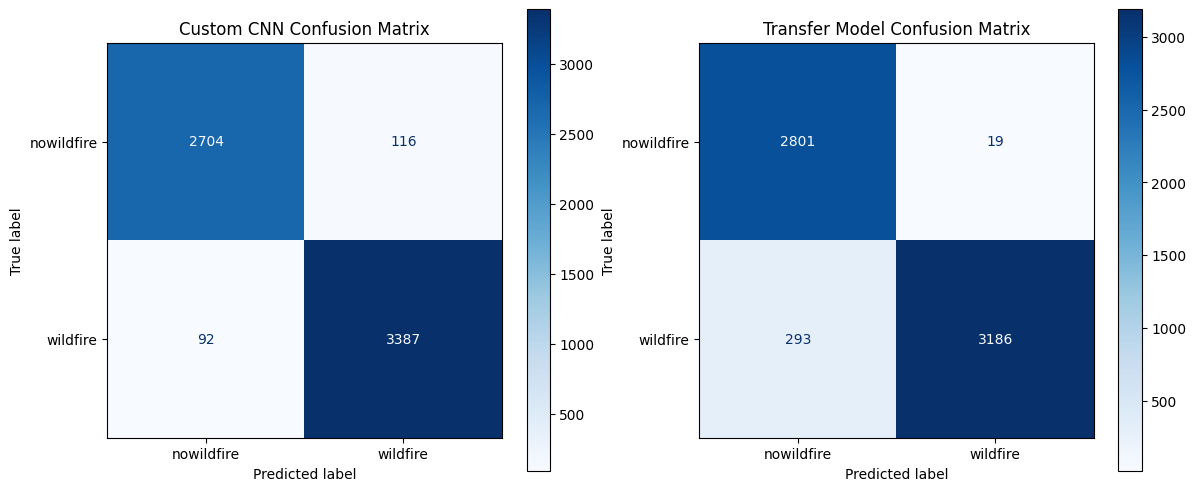

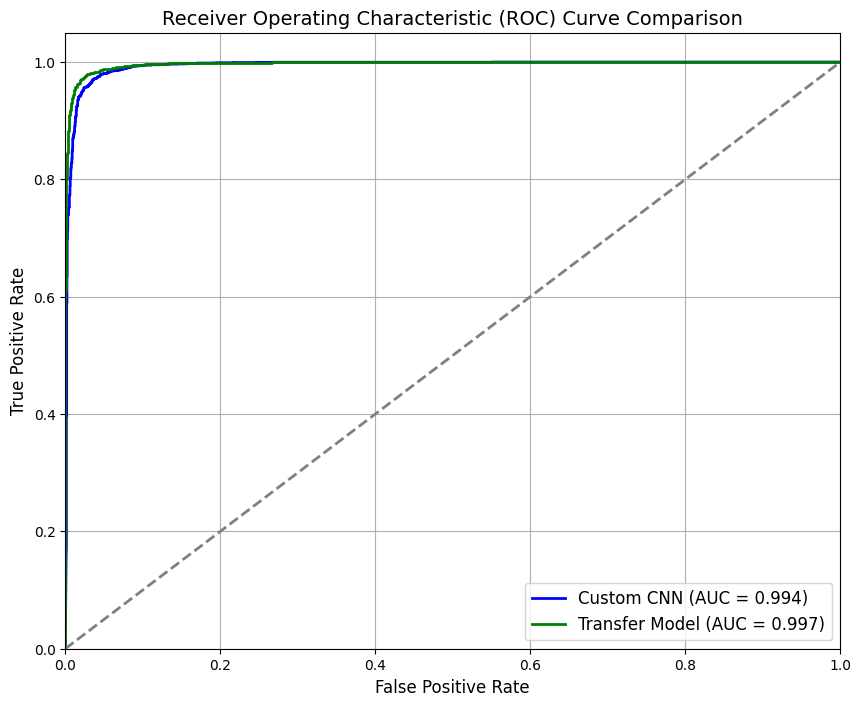

In [45]:
# Plot Confusion Matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred_cnn, display_labels=class_names, ax=ax1, cmap=plt.cm.Blues)
ax1.set_title('Custom CNN Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(y_true, y_pred_transfer, display_labels=class_names, ax=ax2, cmap=plt.cm.Blues)
ax2.set_title('Transfer Model Confusion Matrix')
plt.show()

# Plot ROC Curves
fpr_cnn, tpr_cnn, _ = roc_curve(y_true, y_pred_cnn_prob)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)
fpr_transfer, tpr_transfer, _ = roc_curve(y_true, y_pred_transfer_prob)
roc_auc_transfer = auc(fpr_transfer, tpr_transfer)

plt.figure(figsize=(10, 8))
plt.plot(fpr_cnn, tpr_cnn, color='blue', lw=2, label=f'Custom CNN (AUC = {roc_auc_cnn:.3f})')
plt.plot(fpr_transfer, tpr_transfer, color='green', lw=2, label=f'Transfer Model (AUC = {roc_auc_transfer:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()